<a href="https://colab.research.google.com/github/lcbjrrr/fiap-bdt-ml/blob/master/COVID19_Global_Forecasting_(Week_2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import libs and upload datasets

In [0]:
from google.colab import drive
import seaborn as sns
from sklearn.linear_model import LinearRegression
import pandas as pd
from sklearn import metrics
import statsmodels.api as sm
import matplotlib.pyplot as plt
from datetime import datetime, date

drive.mount('/content/drive')
train = pd.read_csv("/content/drive/My Drive/Colab Notebooks/COVID-19/data/train.csv")
test = pd.read_csv("/content/drive/My Drive/Colab Notebooks/COVID-19/data/test.csv")
submission = pd.read_csv("/content/drive/My Drive/Colab Notebooks/COVID-19/data/submission.csv")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Data exploration


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


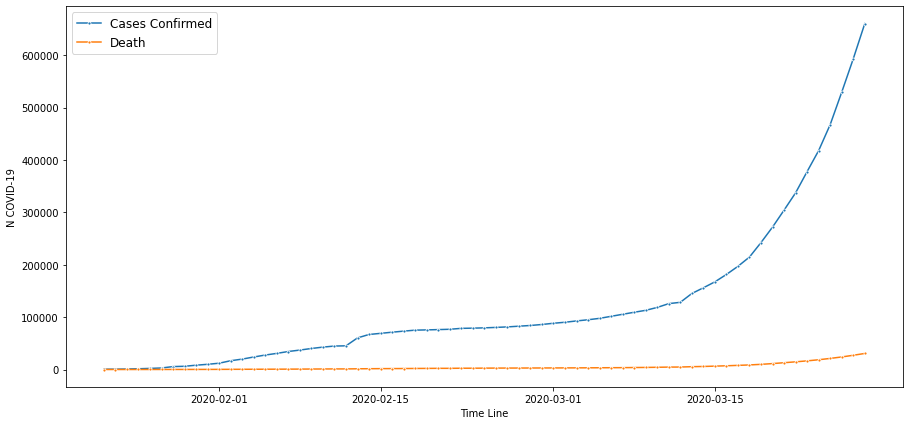

In [0]:
fig, ax1 = plt.subplots(figsize=(15, 7))

df = pd.melt(train, id_vars="Date", value_vars=["ConfirmedCases","Fatalities"], value_name="number")
total = pd.DataFrame({
    'Date': df['Date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d')) ,
    'type': df['variable'],
    'number': df['number'].apply(lambda x: float(x)) 
})

train_cross = pd.crosstab(index=total['Date'],columns=total.type,values=total.number,aggfunc='sum',margins=True)
train_cross['Date'] = train_cross.index
train_cross = train_cross.drop(["All"])
sns.lineplot(x="Date" ,y="ConfirmedCases", marker='.',data=train_cross, label = "Cases Confirmed")
sns.lineplot(x="Date" ,y="Fatalities", marker='.',data=train_cross, label="Death")
plt.ylabel('N COVID-19')
plt.xlabel('Time Line')
plt.legend(fontsize=12)

Based on month march of 'train' base, create a predict model to april

In [0]:
#create model
train_cross['date_ordinal'] = train_cross['Date'].apply(lambda x: x.toordinal())
train_cross['days'] = train_cross['Date'].apply(lambda x: x.toordinal())- date(2019,12,31).toordinal()
rlConfirmed = LinearRegression()
rlFatalities =LinearRegression()

march_train = train_cross.loc[date(year=2020,month=3,day=1):date(year=2020,month=3,day=30)]
# total_confirmed = train_cross.loc[total['type'] == "ConfirmedCases"]
rlConfirmed.fit( march_train[['date_ordinal']] , march_train['ConfirmedCases'])

# total_fatalities = total.loc[total['type'] == "Fatalities"]
rlFatalities.fit( march_train[['date_ordinal']] , march_train['Fatalities'])
print(rlConfirmed.coef_,rlConfirmed.intercept_)


[18233.37383689] -13446852673.932127


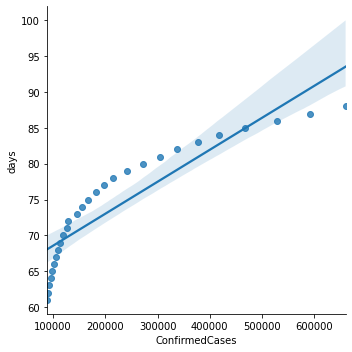

In [0]:
sns.lmplot('ConfirmedCases','days',data=march_train)

In [0]:
#create april range
april = pd.date_range('2020-04-01', periods=30, freq='D')
april_df = pd.DataFrame({
    'Date': april.map(datetime.toordinal)
})

# #test
# teste_date = test.groupby('Date')
# test_predict_df = pd.DataFrame({
#     'Date': teste_date['Date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d')).map(datetime.toordinal)
# })

# #predict april number os confirmed cases
# test_predict_conf = rlConfirmed.predict(test_predict_df)
# test_predict = rlFatalities.predict(test_predict_df)

april_predict_confirmed = rlConfirmed.predict(april_df)
april_predict_fatalities = rlFatalities.predict(april_df)

In [0]:
train_cross.tail()

type,ConfirmedCases,Fatalities,All,Date,date_ordinal,days
Date,,,,,,
2020-03-24 00:00:00,417892.0,18623.0,436515.0,2020-03-24 00:00:00,737508,84
2020-03-25 00:00:00,467504.0,21179.0,488683.0,2020-03-25 00:00:00,737509,85
2020-03-26 00:00:00,529342.0,23966.0,553308.0,2020-03-26 00:00:00,737510,86
2020-03-27 00:00:00,593012.0,27192.0,620204.0,2020-03-27 00:00:00,737511,87
2020-03-28 00:00:00,660329.0,30646.0,690975.0,2020-03-28 00:00:00,737512,88


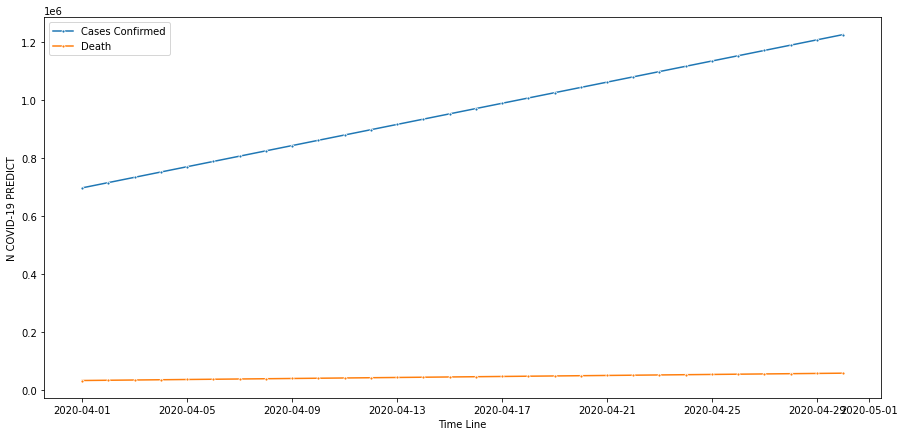

In [0]:
fig, ax1 = plt.subplots(figsize=(15, 7))
april_df_predict = pd.DataFrame({
    'Date': april.map(datetime.date),
    'ConfirmedCases': april_predict_confirmed + train_cross.ConfirmedCases.std(),
    'Fatalities' : april_predict_fatalities + train_cross.Fatalities.std()
})

sns.lineplot(x="Date" ,y="ConfirmedCases", marker='.',data=april_df_predict, label = "Cases Confirmed")
sns.lineplot(x="Date" ,y="Fatalities", marker='.',data=april_df_predict, label="Death")
plt.ylabel('N COVID-19 PREDICT')
plt.xlabel('Time Line')
plt.legend(fontsize=10)

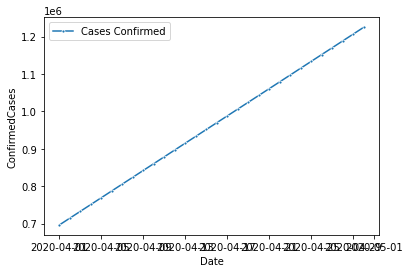

In [0]:
sns.lineplot(x="Date" ,y="ConfirmedCases", marker='.',data=april_df_predict, label = "Cases Confirmed")

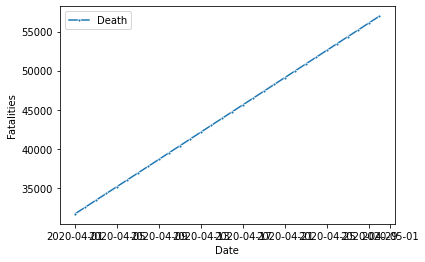

In [0]:
sns.lineplot(x="Date" ,y="Fatalities", marker='.',data=april_df_predict, label="Death")

<h1>Conclusão 1 Regressão linear</h1>
<b>A partir da análise de regressão linear, é possível identificar que o número de morte e de novos casos para abril será crescente</b>



---



---



<h1>Análise do modelo utilizando cluster Kmeans</h1>

Utilizamos a base de treino que possui separação por país, casos confirmados e números de mortos. Rodamos um modelo em cima das variáveis 'ConfirmedCases' e 'Fatalities', e dividimos em clusters.

In [0]:
from sklearn.cluster import KMeans
k = KMeans(n_clusters=5)
k.fit(train[['ConfirmedCases']],  train[['Fatalities']])


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

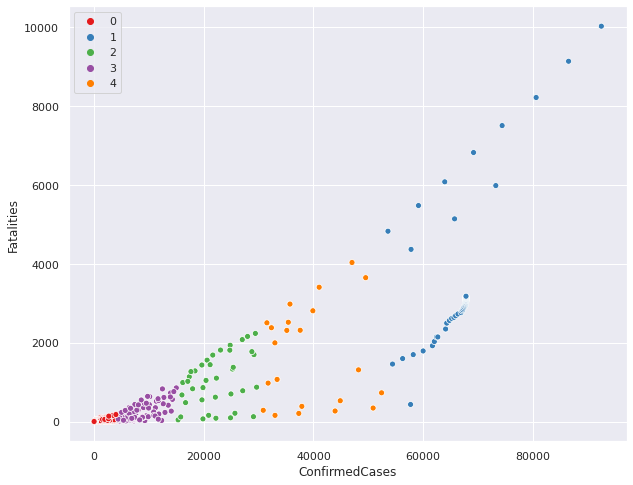

In [0]:
sns.set(rc={'figure.figsize':(10,8)})
sns.scatterplot(train['ConfirmedCases'],train['Fatalities'], hue=k.labels_, palette=sns.color_palette('Set1',5), sizes=(20, 200))

Atualmente, baseado no link [Classificação quarentena](https://www.bbc.com/portuguese/internacional-52040808) existem 4 grupos de quarentena.<br>
Criamos 5 grupos, para definir que o primeiro (0) seriam os paises que ainda não necessitam de quarentena, e com o decorrer do aumento de casos e mortes, a sugestão de qual nível seria ideal o pais adotar

<ul>
  <li>Grau 1- Imunidade de grupo</li>
  <li>Grau 2 - Recomendações e fechamento de escolas e estabelecimentos</li>
  <li>Grau 3 - Toque de recolher noturno</li>
  <li>Grau 4 - Proibição à circulação de pessoas</li>
</ul>
